In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/sbokupripeku/git/side_projects/learning_analytics'

In [825]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from google_trans_new import google_translator  
import json

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
df = pd.read_csv('data/preprocessed_data.csv')

In [135]:
df.tail()

,ISU_ID,GENDER,ADMITTED_EXAMS_SUM,RUSSIAN_LANG,MATH,PHYSICS,CHEMISTRY,FOREIGN_LANG,INFORMATICS,SOCIAL_STUDIES,REGION_ID,CURRENT_STATUS,DROPPED_BEFORE,START_YEAR,AGE_AT_START,HONS_TARGET,DROPPED_TARGET,MARKS_MEAN_SEM_1,MARKS_MEAN_SEM_2,PROGRAM_01,PROGRAM_09,PROGRAM_10,PROGRAM_11,PROGRAM_12,PROGRAM_13,PROGRAM_14,PROGRAM_15,PROGRAM_16,PROGRAM_18,PROGRAM_19,PROGRAM_23,PROGRAM_24,PROGRAM_27,PROGRAM_38,PROGRAM_44,PROGRAM_45,ADMISSION_COND_без вступительных испытаний,ADMISSION_COND_на бюджетное место в пределах особой квоты,ADMISSION_COND_на бюджетное место в пределах целевой квоты,ADMISSION_COND_на выделенное бюджетное место (для жителей Крыма),ADMISSION_COND_на контрактной основе,ADMISSION_COND_по общему конкурсу,RUSSIAN_LANG_BIN,MATH_BIN,PHYSICS_BIN,CHEMISTRY_BIN,FOREIGN_LANG_BIN,INFORMATICS_BIN,SOCIAL_STUDIES_BIN,Физика,nan,Иностранный язык,Химия,Русский язык,Биология,Информатика,Обществознание,Математика,ADMISSION_TYPE_100 баллов за олимпиаду,ADMISSION_TYPE_ЕГЭ,ADMISSION_TYPE_nan,ADMITTED_SUBJECT_PRIZE_LEVEL_0.0,ADMITTED_SUBJECT_PRIZE_LEVEL_1.0,ADMITTED_SUBJECT_PRIZE_LEVEL_2.0,ADMITTED_SUBJECT_PRIZE_LEVEL_3.0,ADMITTED_SUBJECT_PRIZE_LEVEL_4.0,ADMITTED_SUBJECT_PRIZE_LEVEL_nan,ADMITTED_EXAMS_SUM_BIN,NATIONALITY_Белоруссия,NATIONALITY_Вьетнам,NATIONALITY_КНР,NATIONALITY_Казахстан,NATIONALITY_Киргизия,NATIONALITY_Российская Федерация,NATIONALITY_Таджикистан,NATIONALITY_Туркмения,NATIONALITY_Узбекистан,NATIONALITY_Украина,NATIONALITY_другая страна,MACRO_BIRTH_PLACE_архангельск и ао,MACRO_BIRTH_PLACE_белоруссия,MACRO_BIRTH_PLACE_волгоград и во,MACRO_BIRTH_PLACE_воронеж и во,MACRO_BIRTH_PLACE_вьетнам,MACRO_BIRTH_PLACE_другая страна,MACRO_BIRTH_PLACE_другой город (РФ),MACRO_BIRTH_PLACE_екатеринбург и со,MACRO_BIRTH_PLACE_ижевск и ио,MACRO_BIRTH_PLACE_иркутс и ио,MACRO_BIRTH_PLACE_казань и рт,MACRO_BIRTH_PLACE_казахстан,MACRO_BIRTH_PLACE_киргизия,MACRO_BIRTH_PLACE_кнр,MACRO_BIRTH_PLACE_красноярск и кк,MACRO_BIRTH_PLACE_москва и мо,MACRO_BIRTH_PLACE_мурманск и мо,MACRO_BIRTH_PLACE_нижний новгород и но,MACRO_BIRTH_PLACE_новосибирск и но,MACRO_BIRTH_PLACE_оренбург и оо,MACRO_BIRTH_PLACE_пермь и пк,MACRO_BIRTH_PLACE_петрозаводск и рк,MACRO_BIRTH_PLACE_ростов-на-дону и ро,MACRO_BIRTH_PLACE_самара и со,MACRO_BIRTH_PLACE_санкт-петербург и ло,MACRO_BIRTH_PLACE_саратов и со,MACRO_BIRTH_PLACE_таджикистан,MACRO_BIRTH_PLACE_томск и то,MACRO_BIRTH_PLACE_туркмения,MACRO_BIRTH_PLACE_узбекистан,MACRO_BIRTH_PLACE_украина,MACRO_BIRTH_PLACE_уфа и рб,MACRO_BIRTH_PLACE_челябинск и чо,SCHOLARSHIP_TYPE_Бронзовый ЕГЭ,SCHOLARSHIP_TYPE_Золотой ЕГЭ,SCHOLARSHIP_TYPE_Золотой Олимпиада,SCHOLARSHIP_TYPE_Серебряный ЕГЭ,SCHOLARSHIP_TYPE_Серебряный Олимпиада,SCHOLARSHIP_TYPE_nan,DORMITORY_FOR_STUDY_0.0,DORMITORY_FOR_STUDY_1.0,DORMITORY_FOR_STUDY_nan
20569,265000,1,286.0,98.0,88.0,86.0,86.0,88.0,100.0,78.0,78.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.20,4.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
20570,243784,1,247.0,86.0,78.0,80.0,79.0,88.5,84.0,66.0,NaN,диплом,0.0,2017-09-01,17.0,0.0,1.0,3.75,4.428571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
20571,265389,0,257.0,91.0,82.0,86.0,86.0,88.0,84.0,78.0,75.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.75,5.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
20572,242366,1,252.0,86.0,72.0,86.0,86.0,88.0,100.0,78.0,2.0,обучен,0.0,2018-09-01,18.0,0.0,NaN,4.00,3.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

### Drop rows with NaN

In [136]:
df = df[df.MARKS_MEAN_SEM_1.notna()]

In [137]:
df.shape

(18233, 121)

### Drop unused columns

In [531]:
DROP_COLS = ["HONS_TARGET", # Whether student had diploma with honours, not available at admission.
             "DROPPED_TARGET", # Whether student dropped out or not, not available at admission.
             "ISU_ID", # Id, needed for technical purposes, does not help prediction.
             "MARKS_MEAN_SEM_2", # Grades at 2nd semester, not available at admission.
             "CURRENT_STATUS", # Technical feature, does not help prediction.
             "REGION_ID", # Duplicates other features
            ]

In [687]:
filtered_df = df.drop(columns=DROP_COLS)

### Translate column names in English

In [688]:
original_column_names = list(filtered_df.columns)

In [689]:
original_column_names[30]

'ADMISSION_COND_без вступительных испытаний'

In [690]:
with open('translation.json', 'r', encoding='utf8') as f:
    translation_mapper = json.load(f)

In [691]:
filtered_df = filtered_df.rename(columns=translation_mapper)

In [692]:
filtered_df

,GENDER,ADMITTED_EXAMS_SUM,RUSSIAN_LANG,MATH,PHYSICS,CHEMISTRY,FOREIGN_LANG,INFORMATICS,SOCIAL_STUDIES,DROPPED_BEFORE,START_YEAR,AGE_AT_START,MARKS_MEAN_SEM_1,PROGRAM_01,PROGRAM_09,PROGRAM_10,PROGRAM_11,PROGRAM_12,PROGRAM_13,PROGRAM_14,PROGRAM_15,PROGRAM_16,PROGRAM_18,PROGRAM_19,PROGRAM_23,PROGRAM_24,PROGRAM_27,PROGRAM_38,PROGRAM_44,PROGRAM_45,ADMISSION_COND_without entrance exams,ADMISSION_COND_on budget place by special quota,ADMISSION_COND_on budget place by target quota,ADMISSION_COND_on allocated budget place (Crimea),ADMISSION_COND_on contractual basis,ADMISSION_COND_by regular admission,RUSSIAN_LANG_BIN,MATH_BIN,PHYSICS_BIN,CHEMISTRY_BIN,FOREIGN_LANG_BIN,INFORMATICS_BIN,SOCIAL_STUDIES_BIN,Physics,nan,Foreign language,Chemistry,Russian language,Biology,Informatics,Social studies,Mathematics,ADMISSION_TYPE_100 points for olympiad,ADMISSION_TYPE_USE,ADMISSION_TYPE_nan,ADMITTED_SUBJECT_PRIZE_LEVEL_0.0,ADMITTED_SUBJECT_PRIZE_LEVEL_1.0,ADMITTED_SUBJECT_PRIZE_LEVEL_2.0,ADMITTED_SUBJECT_PRIZE_LEVEL_3.0,ADMITTED_SUBJECT_PRIZE_LEVEL_4.0,ADMITTED_SUBJECT_PRIZE_LEVEL_nan,ADMITTED_EXAMS_SUM_BIN,NATIONALITY_Belorussia,NATIONALITY_Vietnam,NATIONALITY_PRC,NATIONALITY_Kazakhstan,NATIONALITY_Kyrgyzstan,NATIONALITY_Russian Federation,NATIONALITY_Tajikistan,NATIONALITY_Turkmenistan,NATIONALITY_Uzbekistan,NATIONALITY_Ukraine,NATIONALITY_another country,MACRO_BIRTH_PLACE_arkhangelsk,MACRO_BIRTH_PLACE_belorussia,MACRO_BIRTH_PLACE_volgograd,MACRO_BIRTH_PLACE_voronezh,MACRO_BIRTH_PLACE_vietnam,MACRO_BIRTH_PLACE_another country,MACRO_BIRTH_PLACE_another city (Russia),MACRO_BIRTH_PLACE_ekaterinburg,MACRO_BIRTH_PLACE_izhevsk,MACRO_BIRTH_PLACE_irkutsk,MACRO_BIRTH_PLACE_kazan,MACRO_BIRTH_PLACE_kazakhstan,MACRO_BIRTH_PLACE_kyrgyzstan,MACRO_BIRTH_PLACE_prc,MACRO_BIRTH_PLACE_kransoyarsk,MACRO_BIRTH_PLACE_moscow,MACRO_BIRTH_PLACE_murmansk,MACRO_BIRTH_PLACE_nizhny_novgorod,MACRO_BIRTH_PLACE_novosibirsk,MACRO_BIRTH_PLACE_orenburg,MACRO_BIRTH_PLACE_perm,MACRO_BIRTH_PLACE_petrozavodsk,MACRO_BIRTH_PLACE_rostov-on-don,MACRO_BIRTH_PLACE_samara,MACRO_BIRTH_PLACE_saint-petersburg,MACRO_BIRTH_PLACE_saratov,MACRO_BIRTH_PLACE_tajikistan,MACRO_BIRTH_PLACE_tomsk,MACRO_BIRTH_PLACE_turkmenistan,MACRO_BIRTH_PLACE_uzbekistan,MACRO_BIRTH_PLACE_ukraine,MACRO_BIRTH_PLACE_ufa,MACRO_BIRTH_PLACE_chelyabinsk,SCHOLARSHIP_TYPE_Bronze USE,SCHOLARSHIP_TYPE_Gold USE,SCHOLARSHIP_TYPE_Gold Olympiad,SCHOLARSHIP_TYPE_Silver USE,SCHOLARSHIP_TYPE_Silver Olympiad,SCHOLARSHIP_TYPE_nan,DORMITORY_FOR_STUDY_0.0,DORMITORY_FOR_STUDY_1.0,DORMITORY_FOR_STUDY_nan
4,0,230.0,84.0,77.0,71.0,78.0,77.0,67.0,70.5,0.0,2011-09-01,46.0,3.250000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,1,230.0,84.0,77.0,71.0,78.0,77.0,67.0,70.5,0.0,2013-09-01,26.0,3.400000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
6,1,230.0,84.0,77.0,71.0,78.0,77.0,67.0,70.5,2.0,2004-09-01,16.0,3.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
14,1,230.0,84.0,77.0,71.0,78.0,77.0,67.0,70.5,0.0,2007-09-01,17.0,3.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
16,1,230.0,84.0,77.0,71.0,78.0,77.0,67.0,70.5,0.0,2012-09-01,21.0,4.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [693]:
filtered_df.columns[filtered_df.isna().any()]

Index(['AGE_AT_START'], dtype='object')

In [694]:
filtered_df = filtered_df[filtered_df.AGE_AT_START.notna()]

In [696]:
filtered_df.shape

(18231, 115)

In [697]:
target = filtered_df.MARKS_MEAN_SEM_1
final_df = filtered_df.drop(columns=['MARKS_MEAN_SEM_1'])

In [698]:
final_df['YEAR'] = final_df.START_YEAR.map(lambda x: int(x.split('-')[0]))

In [699]:
final_df.drop(columns=['START_YEAR'], inplace=True)

In [780]:
def get_x_y_until_year(df, target, year_predicted):
    target_train = target[df.YEAR < year_predicted]
    target_test = target[df.YEAR == year_predicted]
    
#     print('y shape: (train, test)')
#     print(target_train.shape, target_test.shape)
    
    df_train = final_df[df.YEAR < year_predicted]
    df_test = final_df[df.YEAR == year_predicted]

    df_train.drop(columns=['YEAR'], inplace=True)
    df_test.drop(columns=['YEAR'], inplace=True)

#     print('X shape: (train, test)')
#     print(df_train.shape, df_test.shape)
    
    X_train = df_train.to_numpy()
    y_train = target_train.to_numpy()
    X_test = df_test.to_numpy()
    y_test = target_test.to_numpy()
    
#     print('Check nans:')
#     print(np.any(np.isnan(X_train)), np.any(np.isnan(y_train)), np.any(np.isnan(X_test)), np.any(np.isnan(y_test)))
    
    return X_train, y_train, X_test, y_test

In [782]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))

### Check model assumptions

To check if LinearRegression is a good choice of a model we check model assumptions:
1) Residuals are normally distributed 

2) Residuals are heteroscedastic

In [809]:
X_train, y_train, X_test, y_test = get_x_y_until_year(final_df, target, 2015)
X_norm_train = scaler.fit_transform(X_train)
X_norm_test = scaler.fit_transform(X_test)

clf = Lasso(alpha=0.0001, tol=0.001)
clf.fit(X_norm_train, y_train)


y_pred = clf.predict(X_norm_train)

residuals = y_pred - y_train

/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


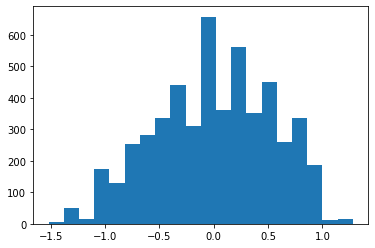

In [821]:
plt.hist(residuals, bins=20);

## Check homeoscedasticity
To do this, plot residuals againts fitted values to see if there is correlation.

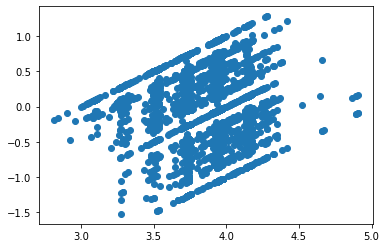

In [824]:
plt.scatter(y_pred, residuals)

In [850]:
import scipy.stats

scipy.stats.pearsonr(y_pred, residuals)

(-0.0006656227339266602, 0.9617853517248984)

The value of -0.0006 can be considered as no correlation. The plot does look strange though.

### Train Linear regression

Train on data before a given year, predict data in the given year.

In [847]:
scaler = StandardScaler()


for year in [2015, 2016, 2017]:
    print(f"Predicting student performance for students admitted in {year}")
    X_train, y_train, X_test, y_test = get_x_y_until_year(final_df, target, year)
    X_norm_train = scaler.fit_transform(X_train)
    X_norm_test = scaler.fit_transform(X_test)
    
    clf = Lasso(alpha=0.000001, tol=0.001)
    clf.fit(X_norm_train, y_train)
    
    print(rmse(clf.predict(X_norm_test), y_test))
    print('---')

Predicting student performance for students admitted in 2015


/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.801e+01, tolerance: 1.741e+00
  model = cd_fast.enet_coordinate_descent(
/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

0.519907079656689
---
Predicting student performance for students admitted in 2016


/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.891e+02, tolerance: 2.597e+00
  model = cd_fast.enet_coordinate_descent(
/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0.5817752459816539
---
Predicting student performance for students admitted in 2017
0.5888887838174504
---


/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+02, tolerance: 3.240e+00
  model = cd_fast.enet_coordinate_descent(


In [848]:
np.sqrt(mean_squared_error(y_pred=clf.predict(X_norm_test), y_true=y_test))

0.5888887838174504

### Feature importance

To assess the importance of various features we run cross-validation on our training data and average the feature weights.

In [800]:
X_train, y_train, X_test, y_test = get_x_y_until_year(final_df, target, 2017)
X_norm_train = scaler.fit_transform(X_train)
X_norm_test = scaler.fit_transform(X_test)

/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [801]:

clf = Lasso(alpha=0.0001, tol=0.001)

output = cross_validate(
    clf,
    X_norm_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=12,
    return_estimator=True,
);

/Users/sbokupripeku/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.359e+00, tolerance: 2.939e+00
  model = cd_fast.enet_coordinate_descent(


In [802]:
coefficients = [cl.coef_ for cl in output['estimator']]
coefficients = np.stack(coefficients)
cv_coefs = np.mean(coefficients, axis=0)

In [803]:
sorted_coef_indices = np.flip(np.argsort(np.abs(cv_coefs)))

columns = df_train.columns.to_numpy()

In [804]:
first_k = 20
large_coefs = [coefs[ind] for ind in sorted_coef_indices[:first_k]]
large_column_names = [columns[ind] for ind in sorted_coef_indices[:first_k]]

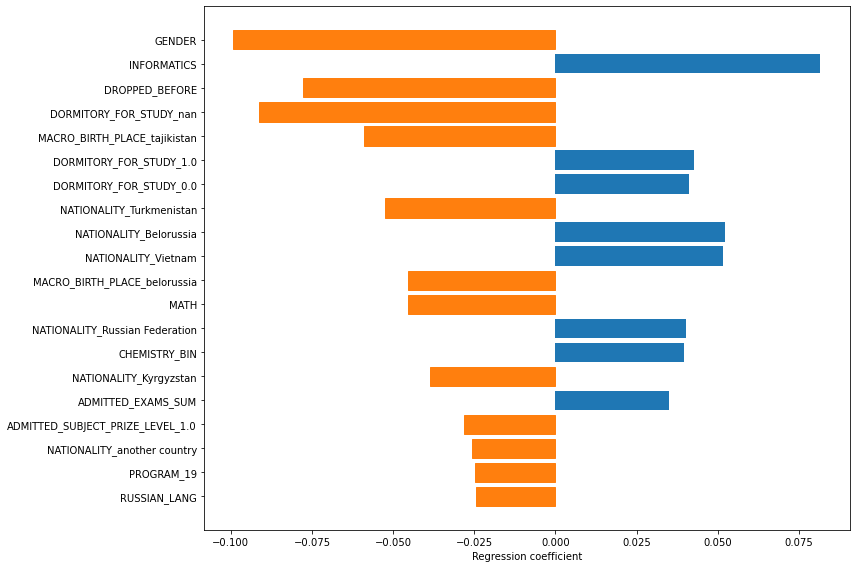

In [805]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

x = list(range(len(large_coefs)))
barlist = ax.barh(x, large_coefs)
for rectangle in barlist:
    if rectangle._width < 0:
        rectangle.set_color('C1')
ax.set_xlabel('Regression coefficient')


plt.yticks(x, large_column_names)
plt.gca().invert_yaxis()
plt.tight_layout()

In [ ]:

# Create table with rmse, write about 4 grade scale (from 2 to 5, with 3 being passing grade)